# Exercise 2. 
The following section presents a yield curve fitting analysis comparing the Nelson–Siegel–Svensson model with a Natural Cubic Spline interpolation, applied to a local sovereign curve that serves as the risk-free benchmark in the Mexican fixed-income market.

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

The data analyzed was sourced from Bloomberg and pertains to the Mexican Sovereign Yield Curve, whose constituent instruments are known as "Bonos M". This curve is considered the Mexican equivalent of the U.S. Treasury yield curve. The maturities range from 1 month to 30 years. The dataset examined corresponds to the Bonos M curve as of August 29, 2025.

In [38]:

# URL to the raw CSV file
url_dataset1 = 'https://raw.githubusercontent.com/macontreras04/cpf/main/SobervgnCurveMX.csv'

# Read the CSV file into a DataFrame
curve_data = pd.read_csv(url_dataset1)
print(curve_data)     


   Tenor  MEXICO SOVEREIGN CURVE
0     1M                   7.865
1     3M                   7.738
2     6M                   7.760
3     1Y                   7.799
4     2Y                   7.770
5     3Y                   8.038
6     4Y                   8.211
7     5Y                   8.340
8     8Y                   8.685
9    10Y                   8.967
10   15Y                   9.220
11   20Y                   9.505
12   25Y                   9.571
13   30Y                   9.582


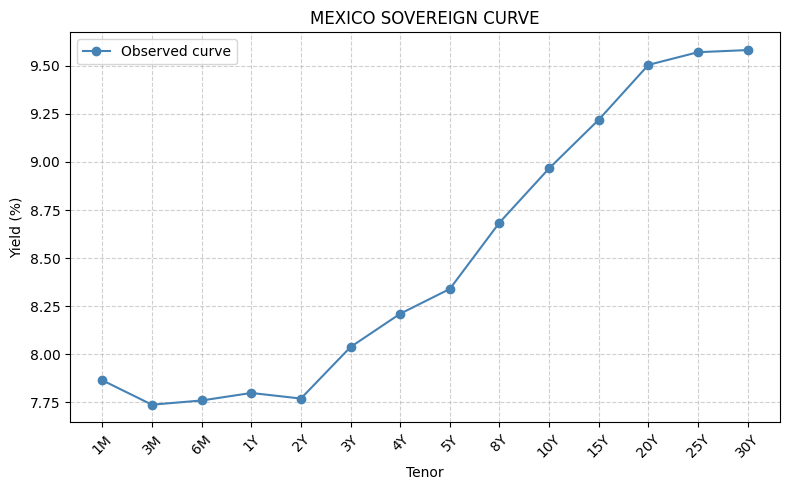

In [39]:
# Example fitted values (replace with your model output)

tenors = ["1M", "3M", "6M", "1Y", "2Y", "3Y", "4Y", "5Y", "8Y", "10Y", "15Y", "20Y", "25Y", "30Y"]


years = curve_data["Tenor"]
yields = curve_data["MEXICO SOVEREIGN CURVE"]

# Plot
plt.figure(figsize=(8,5))
plt.plot(years, yields, 'o-', label="Observed curve", color="steelblue")

# Use tenor strings as x-axis tick labels
plt.xticks(ticks=years, labels=tenors, rotation=45)

plt.xlabel("Tenor")
plt.ylabel("Yield (%)")
plt.title("MEXICO SOVEREIGN CURVE")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


## Nelson-Siegel-Svensson fitting curve

The next step is fit the curve using the NSS model.

In [40]:
# Import the packages for fitting NS model
from nelson_siegel_svensson.calibrate import calibrate_ns_ols

In [41]:

# Conversion dictionary for months and years
tenor_map = {
    "M": 1/12,  # months → years
    "Y": 1      # years → years
}

def tenor_to_years(tenor_str):
    """
    Convert a tenor string like '3M' or '5Y' to a numeric value in years.
    """
    unit = tenor_str[-1].upper()  # Last character (M or Y)
    value = float(tenor_str[:-1])  # All but last character
    return value * tenor_map[unit]

# Apply conversion
curve_data["Tenor (Years)"] = curve_data["Tenor"].apply(tenor_to_years)
print(curve_data)


   Tenor  MEXICO SOVEREIGN CURVE  Tenor (Years)
0     1M                   7.865       0.083333
1     3M                   7.738       0.250000
2     6M                   7.760       0.500000
3     1Y                   7.799       1.000000
4     2Y                   7.770       2.000000
5     3Y                   8.038       3.000000
6     4Y                   8.211       4.000000
7     5Y                   8.340       5.000000
8     8Y                   8.685       8.000000
9    10Y                   8.967      10.000000
10   15Y                   9.220      15.000000
11   20Y                   9.505      20.000000
12   25Y                   9.571      25.000000
13   30Y                   9.582      30.000000


In [42]:
# Create maturity and yield variables in array form
t= np.array(curve_data["Tenor (Years)"])
y = np.array(curve_data["MEXICO SOVEREIGN CURVE"])
print(t)
print(y)


[ 0.08333333  0.25        0.5         1.          2.          3.
  4.          5.          8.         10.         15.         20.
 25.         30.        ]
[7.865 7.738 7.76  7.799 7.77  8.038 8.211 8.34  8.685 8.967 9.22  9.505
 9.571 9.582]


In [43]:
# Fit an NS model for yields from 2020-01-10
curve, status = calibrate_ns_ols(t, y, tau0=1.0)  # starting value of 1.0 for the optimization of tau
assert status.success
print(curve)


NelsonSiegelCurve(beta0=np.float64(9.966885860131061), beta1=np.float64(-2.142866494533559), beta2=np.float64(-2.829408158630271), tau=np.float64(2.1132998383635364))


The NS model result shows the estimated $\beta_{0}$, $\beta_{1}$, $\beta_{2}$, and decay rate. Now let's plot the graph to better understand the model result.

Text(0.5, 1.0, 'Mexico Sovereign Yield Curve NSS Model Result')

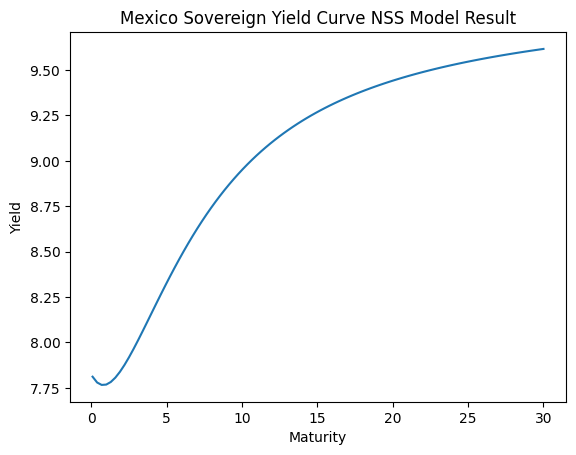

In [44]:
y_hat = curve
t_hat = np.linspace(0.083333,30,100)
plt.plot(t_hat, y_hat(t_hat))
plt.xlabel("Maturity")
plt.ylabel("Yield")
plt.title("Mexico Sovereign Yield Curve NSS Model Result")


## Cubic Spline fiting curve

Now we I'll fit the mexican sov. curve using natural cubic spline.

Text(0.5, 1.0, 'Mexico Sovereign Yield Curve Nat. Cub. Spline Model Result')

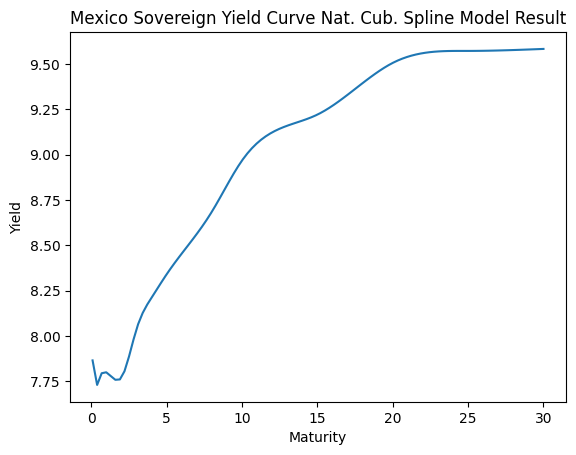

In [45]:
from scipy.interpolate import CubicSpline

# Natural cubic spline (second derivative = 0 at endpoints)
cs = CubicSpline(t, y, bc_type='natural')

# Evaluate the spline on a finer grid
t_new = np.linspace(0.083333,30,100)
y_new = cs(t_new)

plt.plot(t_new, y_new)
plt.xlabel("Maturity")
plt.ylabel("Yield")
plt.title("Mexico Sovereign Yield Curve Nat. Cub. Spline Model Result")


Shown below is the original Bloomberg chart capturing the shape of the Mexican Sovereign Yield Curve — the country’s key reference for risk-free rates across the maturity spectrum.

In [46]:
from IPython.display import Image, display

url = 'https://raw.githubusercontent.com/macontreras04/cpf/main/Bloomberg_Chart.png'
display(Image(url=url))


# Comparison of Nelson–Siegel–Svensson (NSS) and Natural Cubic Spline Yield Curve Models

---

## 1 Model Comparison — Fit

### **Nelson–Siegel–Svensson (NSS)**

**Functional form:**

$$
y(t) = \beta_0 
+ \beta_1 \frac{1 - e^{-t / \tau_1}}{t / \tau_1}
+ \beta_2 \left( \frac{1 - e^{-t / \tau_1}}{t / \tau_1} - e^{-t / \tau_1} \right)
+ \beta_3 \left( \frac{1 - e^{-t / \tau_2}}{t / \tau_2} - e^{-t / \tau_2} \right)
$$

**Fit characteristics:**

- Produces a **smooth and monotonic** curve.  
- Captures the **overall term structure** (level, slope, curvature).  
- May miss **short-term local fluctuations** due to its low-parameter nature.  
- Ideal for **parsimonious, stable, and interpretable** yield curves.

---

### **Natural Cubic Spline**

**Functional form:**

A spline is a **piecewise cubic polynomial** between adjacent maturities (“knots”)  
such that the first and second derivatives are continuous.

$$
S_i(t) = a_i + b_i (t - t_i) + c_i (t - t_i)^2 + d_i (t - t_i)^3, \quad t_i \le t \le t_{i+1}
$$

**Fit characteristics:**

- **Highly flexible** — can interpolate observed yields exactly.  
- Captures local **bumps and curvature**, even with sparse data.  
- Prone to **overfitting** or generating **unrealistic oscillations**.  
- Poor extrapolation at long maturities (beyond last knot).

---

### **Fit Comparison Summary**

| Aspect | Nelson–Siegel–Svensson | Natural Cubic Spline |
|--------|-------------------------|----------------------|
| Type | Parametric (theoretical) | Non-parametric (empirical) |
| Smoothness | Very smooth, monotonic | Locally flexible, may oscillate |
| Overfitting Risk | Low | Higher |
| Short-term Fit | Moderate | Excellent |
| Long-term Behavior | Controlled by decay parameters | Unconstrained |
| Interpretability | High (economic meaning) | Low (no economic meaning) |

---



## 2 Interpretation at the Parameter Level

| Parameter | Meaning | Interpretation |
|------------|----------|----------------|
| **$\beta_0$** | Long-term level | Asymptotic yield as $t \to \infty$. Sets overall curve height (≈ 9.5%). |
| **$\beta_1$** | Short-term slope | Controls steepness between short and long maturities. Negative value ⇒ upward-sloping curve. |
| **$\beta_2$** | Medium-term curvature | Governs hump around intermediate maturities (3–10Y). |
| **$\beta_3$** | Long-term curvature (Svensson extension) | Adds flexibility for a second hump at long maturities (15–25Y). |
| **$\tau_1, \tau_2$** | Decay parameters | Determine how quickly slope and curvature effects decay with maturity. |

In contrast, the **spline model** has no interpretable parameters — its coefficients $a_i, b_i, c_i, d_i$ only describe polynomial shapes between knots, **without economic meaning**.

If I had to choose between the Nelson–Siegel–Svensson (NSS) model and the Natural Cubic Spline (NCS) approach, I would favor NCS. It is widely regarded as the market standard for yield curve interpolation, particularly during curve calibration — a process commonly referred to as bootstrapping.

In practice, several variations of this method interpolate not directly on yields but on discount factors, which are iteratively solved throughout the bootstrapping procedure. Among these, the most prominent are the log-linear and log-spline techniques applied to discount factors.

From my own experience calibrating zero-coupon swap curves, I typically employ a log-linear interpolation during bootstrapping. However, in the case of Mexican sovereign curves, I have found that using a log-spline interpolation on discount factors produces a superior fit — yielding discount factors and zero-coupon rates that closely align with the reference curve published by Bloomberg.

---




## 3 Ethical Discussion — Is Nelson–Siegel “Smoothing” Unethical?

In *Module 2 Lesson 4 (“Smoothing Data”)*, we learned that smoothing can be unethical **if it hides or distorts data** (e.g., concealing volatility or misleading investors).

However, **Nelson–Siegel smoothing is not unethical**, because:

- It’s an **economically justified** method grounded in term structure theory.  
- Its purpose is **curve estimation**, not manipulation.  
- The parameters are **transparent, replicable, and interpretable**.  
- Smoothing helps eliminate micro-noise from market data to produce a consistent pricing curve.

### Ethical when
- Used to estimate continuous, arbitrage-free yield curves.  
- All assumptions and methods are documented.

### Unethical when
- Used deliberately to **mask yield volatility**, **artificially flatten curves**, or **manipulate valuations**.

---

# Final Summary

| Dimension | Nelson–Siegel–Svensson | Natural Cubic Spline |
|------------|-------------------------|----------------------|
| Fit quality | Smooth, robust | Very flexible, may overfit |
| Interpretability | High — β’s and τ’s have clear economic meaning | None |
| Stability | Excellent | Sensitive to small data changes |
| Ethics | Ethical — justified smoothing | N/A (pure interpolation) |

> **Conclusion:**  
> The Nelson–Siegel–Svensson model provides a **smooth, interpretable, and economically meaningful** yield curve.  
> Its smoothing is **methodological, not manipulative**, and therefore **not unethical**.  
> The Natural Cubic Spline, while flexible, lacks interpretability and can introduce spurious curvature if used without care.


# Bibliography

 1. Filipović, D. (2009). Term-Structure Models: A Graduate Course. Springer Finance.
 2. Brigo, D., & Mercurio, F. (2006). Interest Rate Models — Theory and Practice. Springer Finance.
 3. Andersen, L., & Piterbarg, V. (2010). Interest Rate Modeling, Vols. 1–3. Atlantic Financial Press.
 4. Nelson, C. R., & Siegel, A. F. (1987). “Parsimonious Modeling of Yield Curves.” Journal of Business, 60(4), 473–489.
 5. Svensson, L. E. O. (1994). “Estimating and Interpreting Forward Interest Rates: Sweden 1992–1994.” IMF Working Paper 94/114.
 6. Waggoner, D. (1997). “Spline Methods for Extracting Interest Rate Curves from Coupon Bond Prices.” Federal Reserve Bank of Atlanta Working Paper 97-10.